# Processing TROPOMI $\mathrm{H_2O}$ Data

Author: James Yoon (jyyoon@uw.edu)

---

Last updated: 21 May 2025

This script reads in TROPOMI $\mathrm{H_2O}$ data and puts it into various Python data structures! This is version 1 of the script and just does simple regridding. 

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import geopandas as gpd
from satellite_processing_functions import convert_to_string, new_grid, read_scattered_TROPOMI_HDO, regrid_scattered_data
import shapely

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

---

## User-Defined Parameters

Change the variables below to fit your desired configuration!

In [2]:
prefix = '/home/disk/hermes4/jyyoon/H2O/tropomi.grid.surfsara.nl/hdo/' # Change to your prefix
geolocation_bounds = [-180 + 0.625, -90, 180, 90 + 0.625] # in [lon_min, lat_min, lon_max, lat_max]; set to 0 if you don't want any bounds!

year_num = np.array([2021]) # Specify the years of interest. # Could be np.arange(2018, 2025)
month_num = np.array([1]) # Specify the months (by number, e.g. January = 1) # Could be np.arange(1, 13)
day_num = np.array([1]) # Specify a Numpy array with all of the dates in ascending order. # Could be np.arange(1, 32)

# Parameters that define our desired grid
cell_size_lat = 0.5
cell_size_lon = 0.625

---

## Don't change anything below this cell unless you need to!

In [3]:
data_type = 'H2O' # Specify water + HDO retrieval

years = convert_to_string(year_num, 'year');
months = convert_to_string(month_num, 'month');
dates = convert_to_string(day_num, 'day');

new_grid_interp = new_grid(geolocation_bounds[0], geolocation_bounds[1], geolocation_bounds[2], geolocation_bounds[3], cell_size_lat, cell_size_lon) # Creates new grid to interpolate onto.

In [4]:
for year in years:
    for month in months:
        for day in dates:
            daily_df = pd.DataFrame() # Stores daily data
            regridded_daily_df = pd.DataFrame() # Stores regridded daily data -- zero out just in case!

            date_string = f"{year}-{month}-{day}";
            fns = glob(f"{prefix}{year}/{month}/{day}/*/*.nc") # Array with all of that day's swaths

            for fn in fns:
                df_i = read_scattered_TROPOMI_HDO(fn, bounds = geolocation_bounds); # Read in each swath

                if (len(daily_df) == 0) & (len(df_i) > 0):
                    daily_df = df_i
                elif (len(df_i) > 0):
                    daily_df = pd.concat([daily_df, df_i], axis = 0)

            # If there is data on that day, regrid!
            if len(daily_df) > 0: 
                regridded_daily_df = regrid_scattered_data(daily_df[['h2o_column', 'hdo_column', 'deltad', 'geometry']], new_grid_interp, data_type);
                regridded_daily_df['time'] = pd.to_datetime(date_string);
                regridded_daily_df = regridded_daily_df.set_index(['time', 'lat', 'lon']).to_xarray()

                # regridded_daily_df.to_netcdf(f"H2O_TROPOMI_{year}{month}{day}.nc");

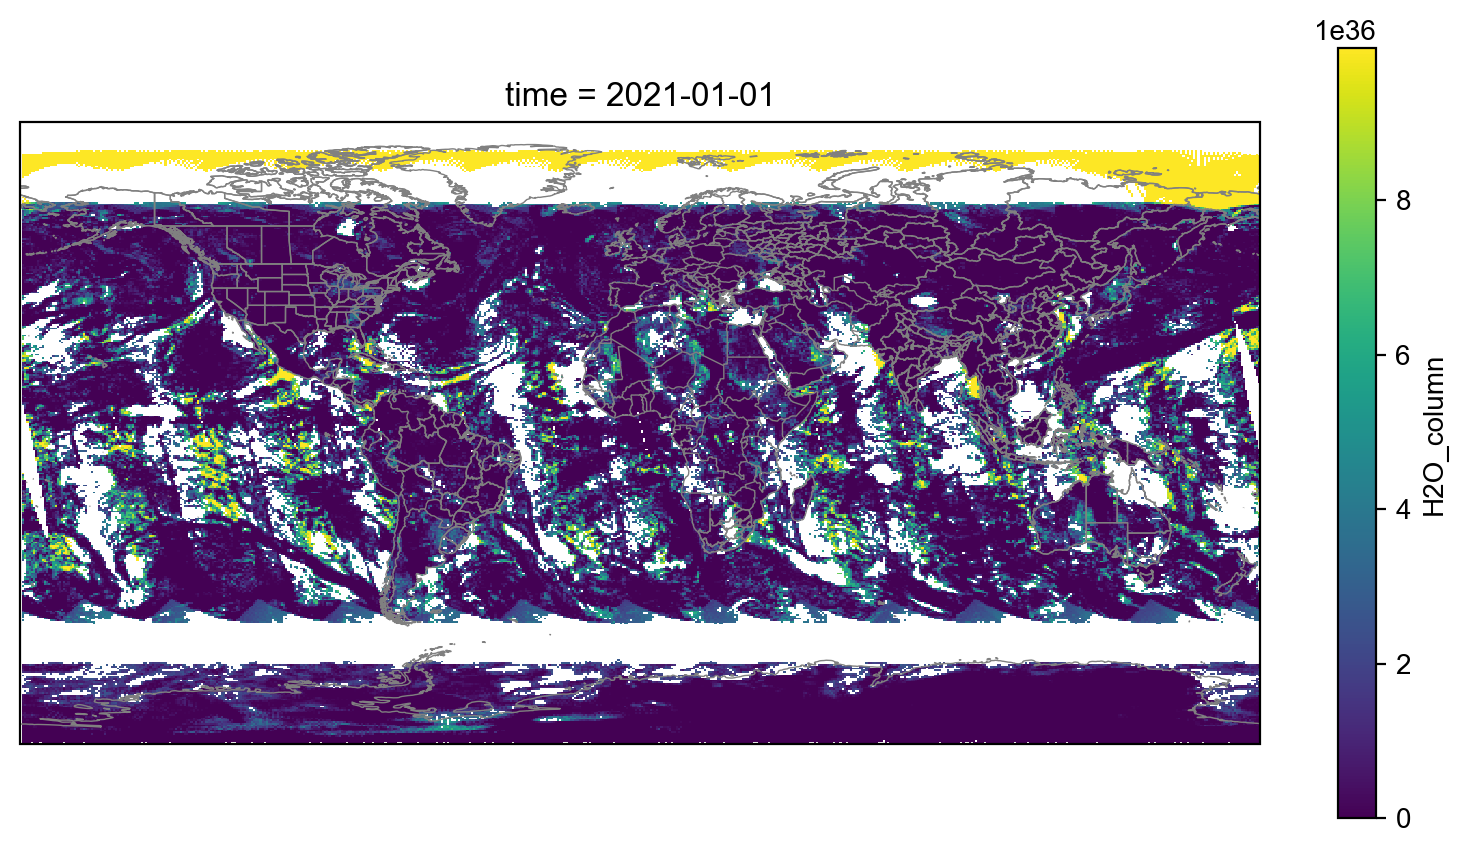

In [5]:
fig, ax = basemap()
regridded_daily_df.H2O_column.plot(ax = ax, transform = ccrs.PlateCarree())

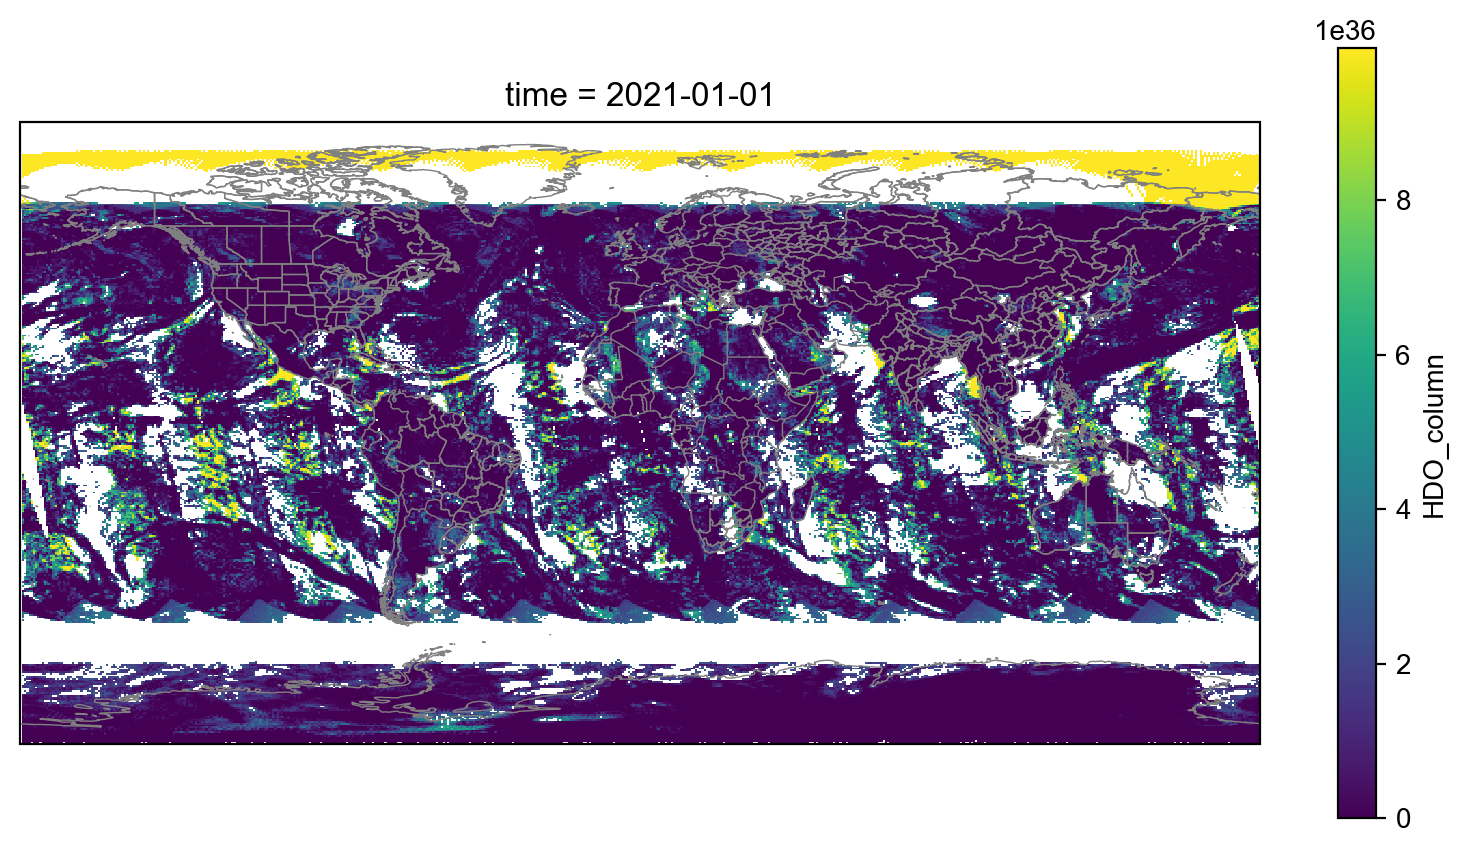

In [6]:
fig, ax = basemap()
regridded_daily_df.HDO_column.plot(ax = ax, transform = ccrs.PlateCarree())

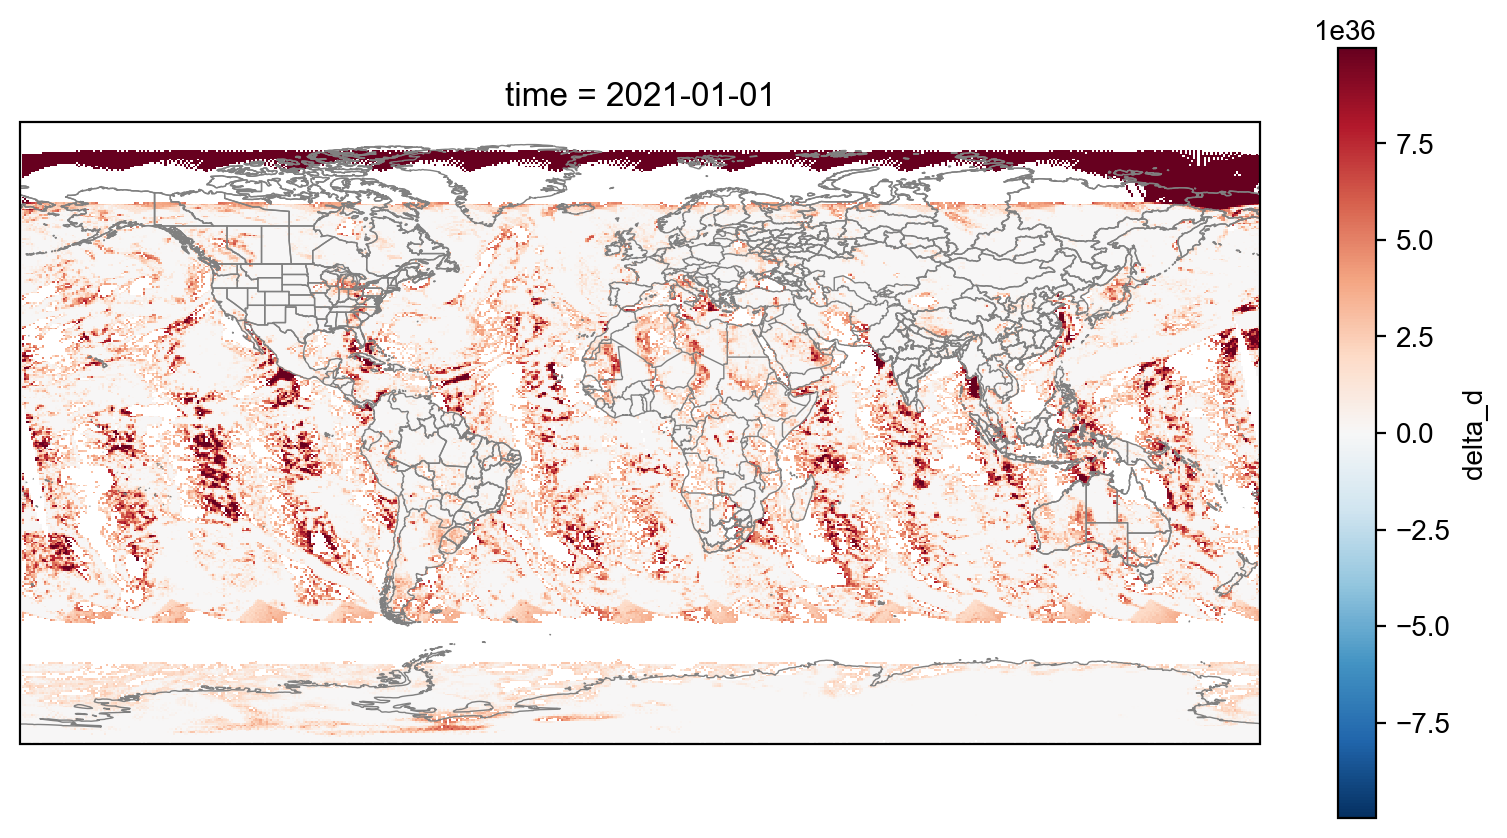

In [7]:
fig, ax = basemap()
regridded_daily_df.delta_d.plot(ax = ax, transform = ccrs.PlateCarree())